# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from utils import *
from usad import *

In [2]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-1e84eb32-9819-cc34-0b25-e159dc3f19e9)


## EDA - Data Pre-Processing

### Load dataset

In [3]:
file = "MQTT_station1"
dataset = pd.read_csv(f'data/{file}_label.csv')

dataset.head(2)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q,label
0,79.0,78495251.0,8449.0,400.0,7397.0,777055.0,30.3,1.0,0.0
1,83.0,78495251.0,768649.0,71828053.0,7398.0,77705251.0,-28.3,1.0,0.0


In [4]:
normal, attack = train_test_split(dataset, test_size=0.9, shuffle=False)
train_size = len(normal)
train_size

238470

### Normal period

In [5]:
normal = normal.drop(["label"], axis=1)
normal.head(5)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q
0,79.0,78495251.0,8449.0,400.0,7397.0,777055.0,30.3,1.0
1,83.0,78495251.0,768649.0,71828053.0,7398.0,77705251.0,-28.3,1.0
2,78.0,78495251.0,8449.0,400.0,81.0,777051.0,25.3,1.0
3,78.0,78495251.0,8449.0,400.0,83.0,777052.0,28.2,1.0
4,78.0,78495251.0,8449.0,400.0,81.0,777051.0,26.4,1.0


#### Normalization

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [7]:
normal.head(5)

,0,1,2,3,4,5,6,7
0,0.500000,0.0,0.000000e+00,0.000005,8.635988e-09,7.242127e-18,0.310047,0.0
1,0.833333,0.0,9.175775e-13,1.000000,8.637168e-09,9.285397e-11,0.115103,0.0
2,0.416667,0.0,0.000000e+00,0.000005,1.180263e-12,2.414042e-18,0.293413,0.0
3,0.416667,0.0,0.000000e+00,0.000005,3.540790e-12,3.621064e-18,0.303061,0.0
4,0.416667,0.0,0.000000e+00,0.000005,1.180263e-12,2.414042e-18,0.297073,0.0


### Attack

In [8]:
attack.head(5)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q,label
238470,78.0,78495251.0,8449.0,400.0,83.0,777052.0,38.2,1.0,0.0
238471,82.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,-2.1,1.0,0.0
238472,81.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,2.1,1.0,0.0
238473,82.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,-2.1,1.0,0.0
238474,81.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,2.1,1.0,0.0


In [ ]:
attack.iloc[3750 : 3772]

In [9]:
#Read data
labels = attack['label'].values
attack = attack.drop(["label"], axis=1)
attack.head(5)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q
238470,78.0,78495251.0,8449.0,400.0,83.0,777052.0,38.2,1.0
238471,82.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,-2.1,1.0
238472,81.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,2.1,1.0
238473,82.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,-2.1,1.0
238474,81.0,78495251.0,768649.0,71828051.0,7398.0,77705249.0,2.1,1.0


#### Normalization

In [10]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [11]:
attack.head(2)

,0,1,2,3,4,5,6,7
0,0.416667,0.0,0.000000e+00,0.000005,3.540790e-12,3.621064e-18,0.336327,0.0
1,0.750000,0.0,9.175775e-13,1.000000,8.637168e-09,9.285397e-11,0.202262,0.0


### Windows

In [12]:
window_size=20

In [13]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(238450, 20, 8)

In [14]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(2146217, 20, 8)

## Training

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [16]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0776, val_loss2: 0.0809
Epoch [1], val_loss1: 0.0740, val_loss2: -0.0070
Epoch [2], val_loss1: 0.0670, val_loss2: -0.0278
Epoch [3], val_loss1: 0.0631, val_loss2: -0.0355
Epoch [4], val_loss1: 0.0646, val_loss2: -0.0427
Epoch [5], val_loss1: 0.0647, val_loss2: -0.0466
Epoch [6], val_loss1: 0.0648, val_loss2: -0.0493
Epoch [7], val_loss1: 0.0642, val_loss2: -0.0508
Epoch [8], val_loss1: 0.0637, val_loss2: -0.0519
Epoch [9], val_loss1: 0.0632, val_loss2: -0.0526
Epoch [10], val_loss1: 0.0628, val_loss2: -0.0532
Epoch [11], val_loss1: 0.0623, val_loss2: -0.0536
Epoch [12], val_loss1: 0.0618, val_loss2: -0.0538
Epoch [13], val_loss1: 0.0615, val_loss2: -0.0541
Epoch [14], val_loss1: 0.0614, val_loss2: -0.0544
Epoch [15], val_loss1: 0.0612, val_loss2: -0.0547
Epoch [16], val_loss1: 0.0611, val_loss2: -0.0550
Epoch [17], val_loss1: 0.0608, val_loss2: -0.0551
Epoch [18], val_loss1: 0.0608, val_loss2: -0.0554
Epoch [19], val_loss1: 0.0605, val_loss2: -0.0554
Epoch [20],

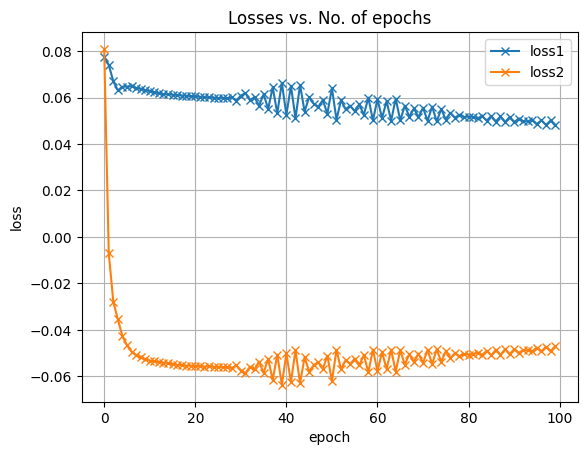

In [17]:
plot_history(history)

In [18]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [2]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

NameError: name 'torch' is not defined

In [20]:
results=testing(model,test_loader)

In [21]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [22]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [23]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [1]:
len(y_pred), len(y_test)

NameError: name 'y_pred' is not defined

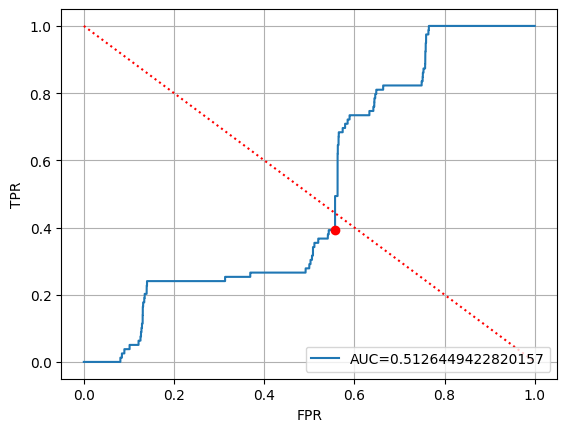

In [27]:
threshold=ROC(y_test,y_pred)

In [28]:
threshold

array([0.02154813], dtype=float32)

In [ ]:
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

In [ ]:
confusion_matrix(np.array(y_test), y_pred_)

In [ ]:
threshold = 10
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_test, y_pred_))

In [ ]:
confusion_matrix(np.array(y_test), y_pred_)

In [ ]:
with open(f'scores/usad_{file}_{train_size}_{window_size}.dat', 'w') as f:
    for i in range(len(y_pred)):
        f.write(str(y_pred[i]) + ';' + str(y_test[i]) + '\n')